In [2]:
%pwd

'/Users/r/Documents/stud/ss24/finnpinn/src'

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
dir_paths = [p for p in Path("../data_out/finn_running_intervals_stepsize_30").glob("finn_running_interval_*") if p.is_dir()]
dir_paths

[PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_1'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_6'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_8'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_9'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_7'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_0'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_10'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_11'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_5'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_2'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_3'),
 PosixPath('../data_out/finn_running_intervals_steps

In [5]:
df = {
    "retardation_file_paths": [],
    "interval_index": [],
    "num_epochs": [],
}
for p in dir_paths:
    all_ret_file_paths = sorted((p / "predicted_retardations").glob("retPred_*.npy"), key=lambda x: int(x.stem.split("_")[-1]))
    if not all_ret_file_paths:
        continue
    df["retardation_file_paths"].append(all_ret_file_paths[-1])
    df["interval_index"].append(int(p.name.split("_")[-1]))
    df["num_epochs"].append(int(all_ret_file_paths[-1].stem.split("_")[-1]))
df = pd.DataFrame(df).sort_values("interval_index").reset_index(drop=True)
df = df[df["interval_index"] < 8]
df = df[df["num_epochs"] >= 100].reset_index(drop=True)
df

,retardation_file_paths,interval_index,num_epochs
0,../data_out/finn_running_intervals_stepsize_30...,0,1000
1,../data_out/finn_running_intervals_stepsize_30...,1,1000
2,../data_out/finn_running_intervals_stepsize_30...,2,1000
3,../data_out/finn_running_intervals_stepsize_30...,3,1000
4,../data_out/finn_running_intervals_stepsize_30...,4,1000
5,../data_out/finn_running_intervals_stepsize_30...,5,1000
6,../data_out/finn_running_intervals_stepsize_30...,6,1000
7,../data_out/finn_running_intervals_stepsize_30...,7,1000


In [6]:
df2 = df.copy()
df2["ret"] = df["retardation_file_paths"].apply(lambda p: np.load(p).ravel())
df2 = df2.explode('ret').reset_index(drop=True)
df2["u"] = np.tile(np.arange(0, 100), len(df))
df2

,retardation_file_paths,interval_index,num_epochs,ret,u
0,../data_out/finn_running_intervals_stepsize_30...,0,1000,4.882407,0
1,../data_out/finn_running_intervals_stepsize_30...,0,1000,4.754845,1
2,../data_out/finn_running_intervals_stepsize_30...,0,1000,4.637146,2
3,../data_out/finn_running_intervals_stepsize_30...,0,1000,4.528736,3
4,../data_out/finn_running_intervals_stepsize_30...,0,1000,4.429045,4
...,...,...,...,...,...
795,../data_out/finn_running_intervals_stepsize_30...,7,1000,3.233056,95
796,../data_out/finn_running_intervals_stepsize_30...,7,1000,3.232769,96
797,../data_out/finn_running_intervals_stepsize_30...,7,1000,3.232578,97
798,../data_out/finn_running_intervals_stepsize_30...,7,1000,3.232483,98


In [7]:
df2.dtypes

retardation_file_paths    object
interval_index             int64
num_epochs                 int64
ret                       object
u                          int64
dtype: object

In [8]:
rng = np.random.default_rng()

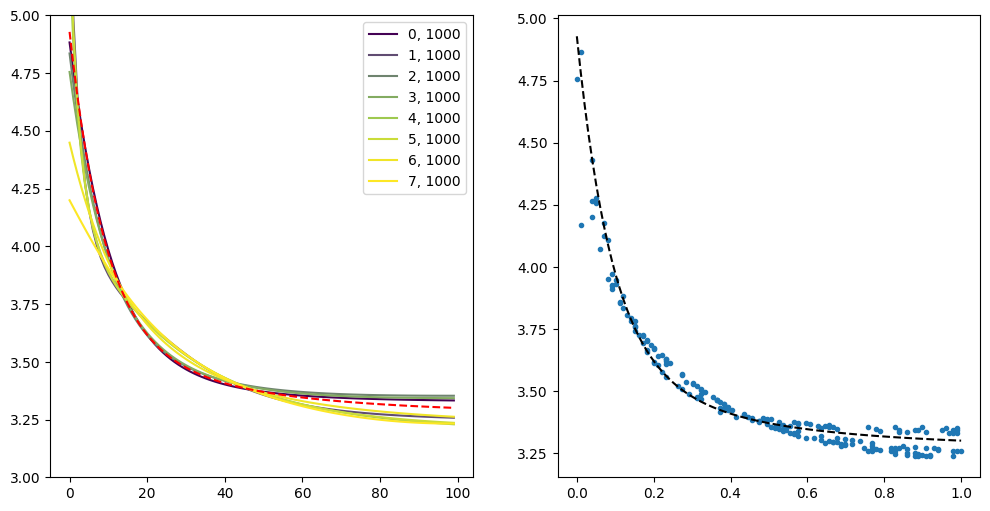

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ret_freundlich = np.load("../data_out/retardation_freundlich.npy")

initial_colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
final_color = initial_colors[-1]

highest_time_step_ret = np.load(df["retardation_file_paths"].iloc[-1])

sampled_u_indices = []
sampled_rs = []
for i, p in enumerate(df["retardation_file_paths"]):
    ret = np.load(p)

    u_index_samples = rng.choice(np.arange(0, 100), 25, replace=False)
    sampled_u_indices.extend(u_index_samples)
    sampled_rs.extend(ret[u_index_samples])

    mixed_color = initial_colors[i] * (1 - i / (len(df) - 1)) + final_color * (i / (len(df) - 1))
    ax1.plot(ret, label=f"{df['interval_index'][i]}, {df['num_epochs'][i]}", color=mixed_color)

sampled_u_indices = np.array(sampled_u_indices)
sampled_us = np.load("../data_out/u_ret.npy")[sampled_u_indices]
sampled_rs = np.array(sampled_rs)
finn_ret = np.load("../data_out/predicted_retardations/retPred_100.npy")
ax2.plot(sampled_us, sampled_rs, ".")
ax2.plot(np.load("../data_out/u_ret.npy"), finn_ret, "k--")

# ax1.plot(ret_freundlich, "r--", label="freundlich")#, color=final_color)
ax1.plot(finn_ret, "r--")
ax1.set_ylim(3,5)
ax1.legend()
plt.show()

# Compute Envelope Curve

In [10]:
all_rets = np.stack([np.load(p) for p in df["retardation_file_paths"]], axis=0).squeeze()
envelope_curve_up = np.max(all_rets, axis=0)
envelope_curve_down = np.min(all_rets, axis=0)

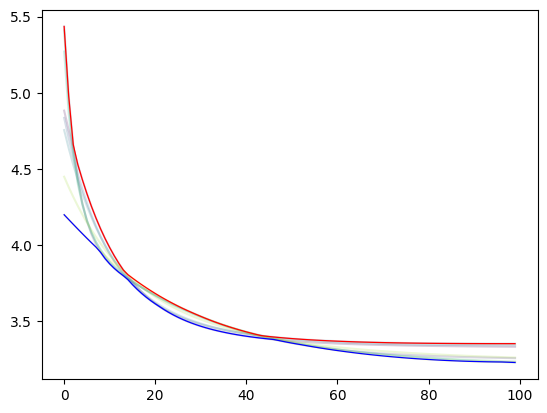

In [19]:
from matplotlib import cm
colormap = cm.viridis

colors = colormap(np.linspace(0, 1, 8))
lines = plt.plot(all_rets.T, alpha=0.2)
plt.plot(envelope_curve_up, "r-", lw=0.9)
plt.plot(envelope_curve_down, "b-", lw=0.9)
# plt.fill_between(x=np.arange(envelope_curve_up.shape[0]), y1=envelope_curve_down, y2=envelope_curve_up, color='green', alpha=0.3)

for line, color in zip(lines, colors):
    line.set_color(color)

plt.show()

## Sample points between curves for 3PINN

In [12]:
import numpy as np

def is_below_curve(curve_x: np.ndarray, curve_y: np.ndarray, points: np.ndarray) -> np.ndarray:
    """
    Checks whether a set of points is below a curve. The curve is a piecewise linear function given by points.

    Args:
        curve_x (np.ndarray): x-coordinates of the curve points
        curve_y (np.ndarray): y-coordinates of the curve points
        points (np.ndarray): (N, 2) array containing the points to check

    Returns:
        np.ndarray: Boolean array indicating whether each point is below the curve.
    """
    # Interpolate the curve using piecewise linear interpolation
    interpolated_y = np.interp(points[:, 0], curve_x, curve_y)
    
    # Compare the y-coordinates of the points with the interpolated y-values of the curve
    below_curve = points[:, 1] < interpolated_y
    
    return below_curve

import numpy as np

def is_above_curve(curve_x: np.ndarray, curve_y: np.ndarray, points: np.ndarray) -> np.ndarray:
    interpolated_y = np.interp(points[:, 0], curve_x, curve_y)
    below_curve = points[:, 1] > interpolated_y
    return below_curve

# Example usage:
# curve_x = np.array([0, 1, 2, 3])
# curve_y = np.array([0, 1, 0.5, 2])
# points = np.array([[0.5, 0.5], [1.5, 0.7], [2.5, 1.5]])
# result = is_below_curve(curve_x, curve_y, points)
# print(result)  # Output: [ True,  True, False]

469 are between


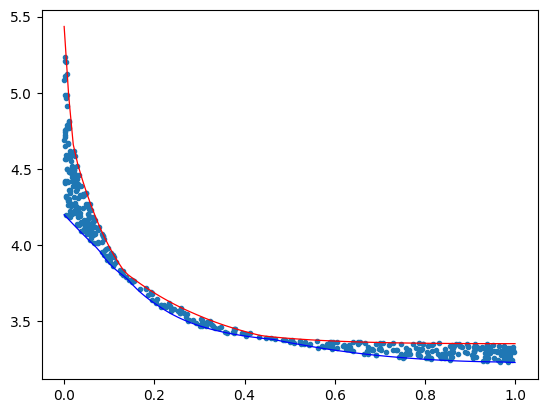

In [18]:
y_max = envelope_curve_up.max()
y_min = envelope_curve_down.min()

rng = np.random.default_rng(2864343564)
rectangle_points = rng.uniform(low=0, high=1, size=(10**4, 2))
rectangle_points[:, 1] = rectangle_points[:, 1] * (y_max - y_min) + y_min

u= np.linspace(0,1,100)
is_below = is_below_curve(u, envelope_curve_up, rectangle_points)
is_above = is_above_curve(u, envelope_curve_down, rectangle_points)
is_between = is_below * is_above

envelope_points = rectangle_points[is_between]
print(f"{len(envelope_points)} are between")

u = np.linspace(0,1,len(envelope_curve_up))
plt.plot(*envelope_points.T, ".")
plt.plot(u, envelope_curve_up, "r-", lw=0.9)
plt.plot(u, envelope_curve_down, "b-", lw=0.9)
plt.show()

### Comparison with only different seeds

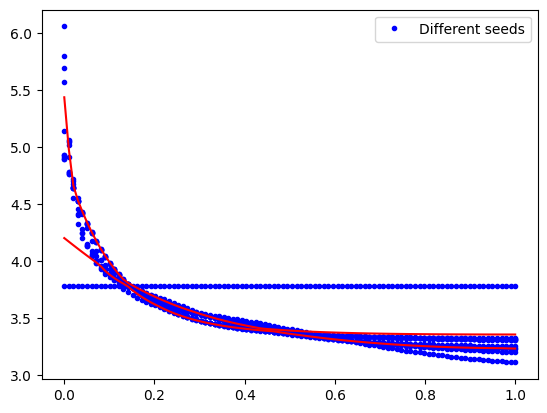

In [ ]:
base_dir = Path("../data_out/finn_different_seeds")

fig, ax = plt.subplots()

i = 0
for d in base_dir.iterdir():
    try:
        path = d / "predicted_retardations/retPred_100.npy"
        # print(path)
        ret = np.load(path)
    except FileNotFoundError:
        # print(f"File not found: {d}")
        continue
    # Continue if any NaNs or Infs are found
    if np.any(np.isnan(ret)) or np.any(np.isinf(ret)):
        continue
    if np.any(ret > 100):
        continue
    
    ax.plot(np.linspace(0,1,len(ret)), ret, "b.", label="Different seeds" if i==0 else "")
    i += 1
    # ax.plot(ret, label=d.name)

# ax.plot(sampled_us, sampled_rs, "rx", label="Different time intervals")
ax.plot(u, envelope_curve_up, "r-")
ax.plot(u, envelope_curve_down, "r-")

ax.legend()
plt.show()

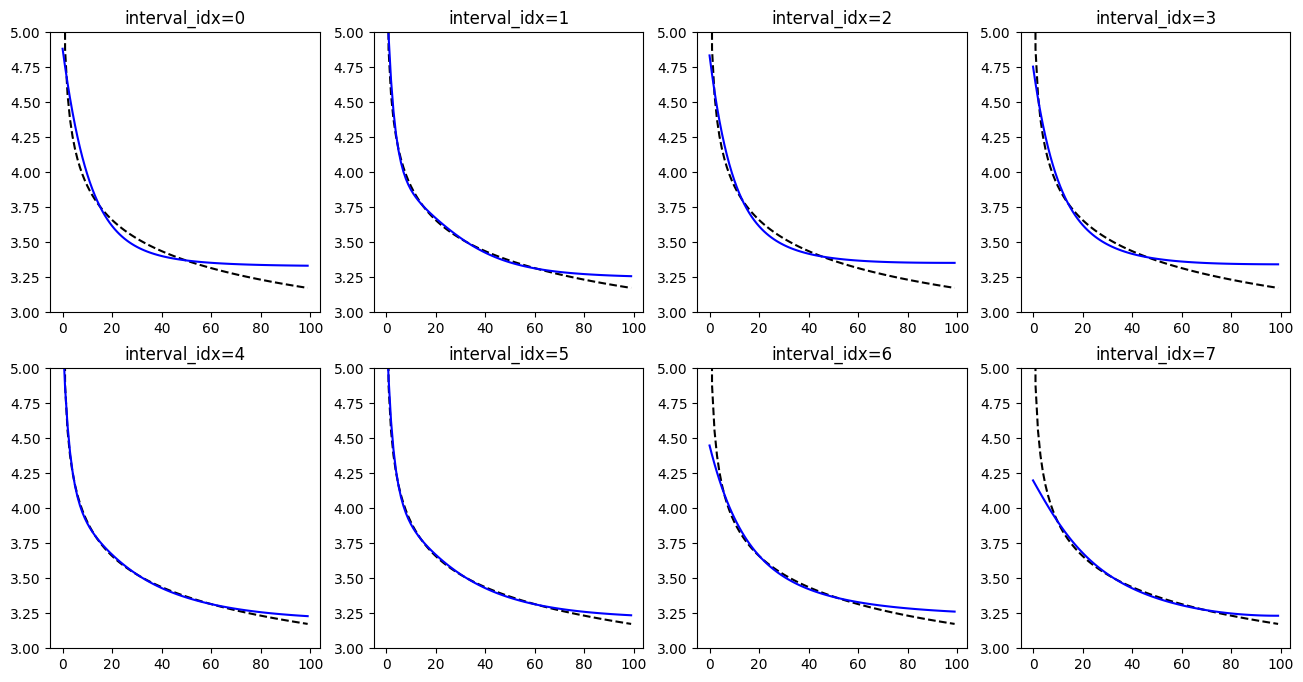

In [ ]:
ret_freundlich = np.load("../data_out/retardation_freundlich.npy")

initial_colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
final_color = initial_colors[-1]

ncols = 4
nrows = int(np.ceil(len(df) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.ravel()

for i, p, ax in zip(range(len(df)), df["retardation_file_paths"], axs):
    ret = np.load(p)
    mixed_color = initial_colors[i] * (1 - i / (len(df) - 1)) + final_color * (i / (len(df) - 1))
    interval_idx = df['interval_index'][i]
    ax.set_title(f"{interval_idx=}")
    ax.plot(ret_freundlich, "k--", label="freundlich")
    ax.plot(ret, "b-")
    ax.set_ylim(3,5)

plt.show()

# Save Dataset for 3PINN

In [ ]:
pinn_base_path = Path("../data_out/3pinn").resolve()
pinn_base_path.mkdir(exist_ok=True, parents=True)
pinn_x_path = pinn_base_path / "x.npy"
pinn_y_path = pinn_base_path / "y.npy"

np.save(pinn_x_path, envelope_points[:, 0])
np.save(pinn_y_path, envelope_points[:, 1])

# Make sub interval training data

In [ ]:
# from pathlib import Path

# path = Path("../data/synthetic_data/retardation_freundlich/sub_intervals/")
# path.mkdir(exist_ok=True, parents=True)

# step_size = 30
# for i in range(10**9):
#     start = i * step_size
#     end = start + step_size
#     arr = c[start:end]
#     if len(arr) != step_size:
#         break
#     np.save(path / f"c_{i}.npy", arr)